In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import json
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Dense, Embedding, Dropout, add
from tensorflow.keras.models import save_model, load_model

2024-04-08 17:49:53.171969: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 17:49:53.172091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 17:49:53.403557: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BASE_DIR = "/kaggle/input/coco-image-caption"
WORK_DIR = "/kaggle/working"

In [3]:
feature_model = ResNet50(include_top=False, input_shape=(224,224,3), pooling='avg')
print(feature_model.summary())

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


## Get Image Data

In [4]:
cap_dir = os.path.join(BASE_DIR, "annotations_trainval2014", "annotations", "captions_train2014.json")
with open(cap_dir, 'r') as f:
    data = json.load(f)["annotations"]

In [5]:
for d in data:
    if d['image_id'] == data[0]['image_id']:
        print(d)

{'image_id': 318556, 'id': 48, 'caption': 'A very clean and well decorated empty bathroom'}
{'image_id': 318556, 'id': 126, 'caption': 'A blue and white bathroom with butterfly themed wall tiles.'}
{'image_id': 318556, 'id': 219, 'caption': 'A bathroom with a border of butterflies and blue paint on the walls above it.'}
{'image_id': 318556, 'id': 255, 'caption': 'An angled view of a beautifully decorated bathroom.'}
{'image_id': 318556, 'id': 3555, 'caption': 'A clock that blends in with the wall hangs in a bathroom. '}


## Get Image Features and Captions

In [6]:
def get_image_feature(img_path, model):
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature

In [7]:
features = {}
captions = {}
img_dir = os.path.join(BASE_DIR, "train2014", "train2014")
for d in tqdm(data[:15000]):
    # import image, preprocess image, store image feature
    img_id = d['image_id']
    if img_id not in features:
        img_path =  os.path.join(img_dir, 'COCO_train2014_'+ format(img_id, '012d') + '.jpg')
        features[img_id] = get_image_feature(img_path, feature_model)
    # get caption, preprocess caption, store caption
    caption = d['caption']
    if img_id not in captions:
        captions[img_id] = []
    caption = caption.lower()
    caption = caption.replace('[^\w\s]', '')
    caption = caption.replace('[^A-Za-z]', '')
    caption = caption.replace('\s+', ' ')
    caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
    captions[img_id].append(caption)

  0%|          | 0/15000 [00:00<?, ?it/s]

I0000 00:00:1712598623.527420      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [8]:
pickle.dump(features, open(os.path.join(WORK_DIR, "features.pkl"), 'wb')) 
pickle.dump(captions, open(os.path.join(WORK_DIR, "captions.pkl"), 'wb')) 

In [9]:
with open(os.path.join(WORK_DIR, "features.pkl"), 'rb') as f:
    features = pickle.load(f)
with open(os.path.join(WORK_DIR, "captions.pkl"), 'rb') as f:
    captions = pickle.load(f)

In [10]:
features[318556]

array([[0.515023  , 0.2802572 , 0.13661857, ..., 1.0544993 , 1.7322754 ,
        1.4709165 ]], dtype=float32)

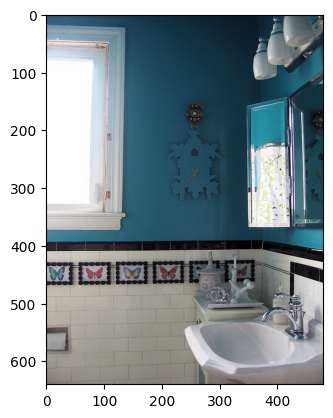

In [11]:
plt.imshow(Image.open(os.path.join(img_dir, 'COCO_train2014_'+ format(318556, '012d') + '.jpg')))

In [12]:
captions[318556]

['startseq very clean and well decorated empty bathroom endseq',
 'startseq blue and white bathroom with butterfly themed wall tiles. endseq',
 'startseq bathroom with border of butterflies and blue paint on the walls above it. endseq',
 'startseq an angled view of beautifully decorated bathroom. endseq',
 'startseq clock that blends in with the wall hangs in bathroom. endseq']

## Tokenize Captions

In [13]:
all_captions = []
for key in captions:
    for caption in captions[key]:
        all_captions.append(caption)

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index)

In [15]:
vocab_size

5100

In [16]:
max_len = max(len(caption.split()) for caption in all_captions)

In [17]:
max_len

30

## Train Test Split

In [18]:
img_ids = list(captions.keys())
split = int(len(img_ids) * 0.9)
train = img_ids[:split]
test = img_ids[split:]

## Data Generator

In [19]:
def data_generator(data_keys, captions, features, tokenizer, max_len, vocab_size, batch_size):
    x1, x2, y = list(), list(), list()
    n = 0
    while True:
        for key in data_keys:
            n += 1
            caps = captions[key]
            for cap in caps:
                seq = tokenizer.texts_to_sequences([cap])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_len)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    x1.append(features[key][0])
                    x2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                x1, x2, y = np.array(x1), np.array(x2), np.array(y)
                yield (x1, x2), y
                x1, x2, y = list(), list(), list()
                n = 0

## Create Model

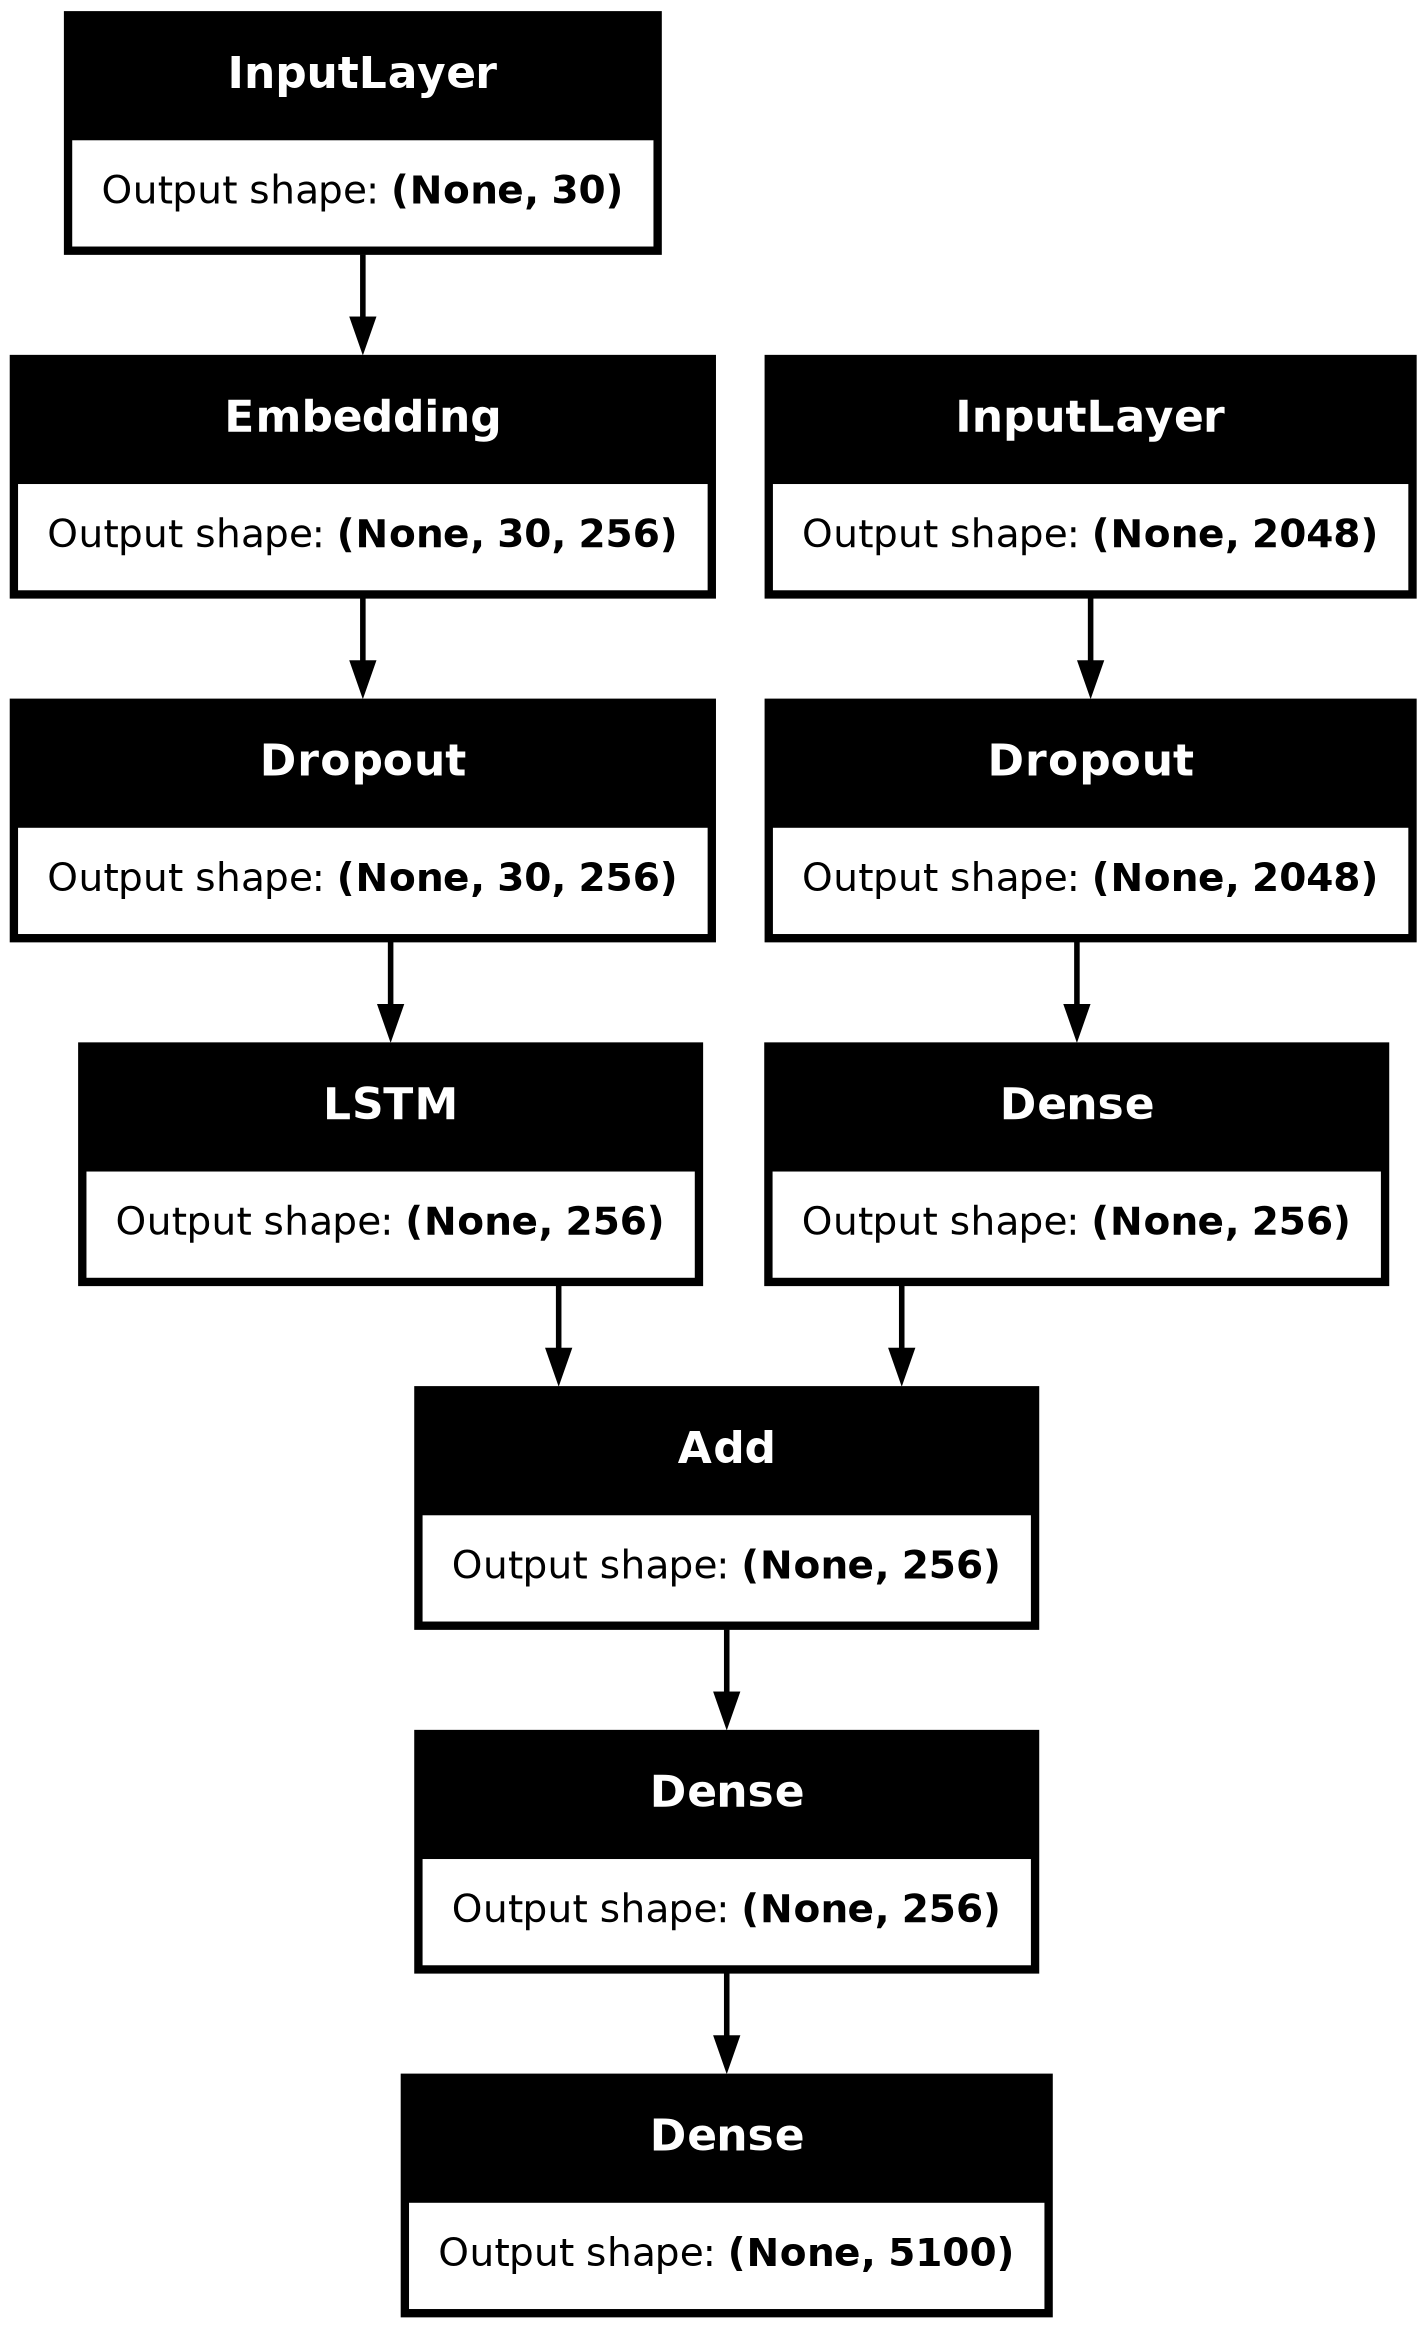

In [20]:
# encoder
# image feature layers
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_len,))
se1 = Embedding(vocab_size, 256)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder
dec1 = add([fe2, se3])
dec2 = Dense(256, activation='relu')(dec1)
outputs = Dense(vocab_size, activation='softmax')(dec2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer="adam")
plot_model(model, show_shapes=True)

In [21]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 30, 256)   │  1,305,600 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5100)      │  1,310,700 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,731,948 (14.24 MB)

 Trainable params: 3,731,948 (14.24 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [22]:
epochs = 20
batch_size = 32
steps = len(train) // batch_size
for i in range(epochs):
    gen = data_generator(train, captions, features, tokenizer, max_len, vocab_size, batch_size)
    model.fit(gen, epochs=1, steps_per_epoch=steps, verbose=1)

86/86 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - loss: 6.1364
86/86 ━━━━━━━━━━━━━━━━━━━━ 16s 184ms/step - loss: 4.7887
86/86 ━━━━━━━━━━━━━━━━━━━━ 16s 185ms/step - loss: 4.1954
86/86 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - loss: 3.8146
86/86 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - loss: 3.5479
86/86 ━━━━━━━━━━━━━━━━━━━━ 16s 185ms/step - loss: 3.3439
86/86 ━━━━━━━━━━━━━━━━━━━━ 16s 185ms/step - loss: 3.1712
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 180ms/step - loss: 3.0313
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 180ms/step - loss: 2.9094
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 180ms/step - loss: 2.7938
86/86 ━━━━━━━━━━━━━━━━━━━━ 16s 182ms/step - loss: 2.7008
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step - loss: 2.6145
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step - loss: 2.5374
86/86 ━━━━━━━━━━━━━━━━━━━━ 16s 182ms/step - loss: 2.4693
86/86 ━━━━━━━━━━━━━━━━━━━━ 16s 182ms/step - loss: 2.4062
86/86 ━━━━━━━━━━━━━━━━━━━━ 16s 182ms/step - loss: 2.3461
86/86 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - loss: 2.2862
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 

In [23]:
save_model(model, WORK_DIR + "/model.h5")

In [24]:
model = load_model(WORK_DIR + "/model.h5")

## Generate Captions

In [25]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [26]:
def predict_caption(model, image, tokenizer, max_len):
    in_text = "startseq"
    for i in range(max_len):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], max_len)
        y = model.predict([image, seq], verbose=0)
        word = idx_to_word(np.argmax(y), tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == "endseq":
            break
    return in_text

## Validation

In [27]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()
for key in tqdm(test):
    actual_caps = captions[key]
    pred_caps = predict_caption(model, features[key], tokenizer, max_len)
    actual.append([c.split() for c in actual_caps])
    predicted.append(pred_caps.split())
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/307 [00:00<?, ?it/s]

BLEU-1: 0.579911
BLEU-2: 0.335628


## Testing

In [28]:
def get_caption(img_path):
    feature = get_image_feature(img_path, feature_model)
    caption = predict_caption(model, feature, tokenizer, max_len)
    caption = ' '.join([word for word in caption.split() if (word != 'startseq' and word != 'endseq')])
    plt.imshow(Image.open(img_path))
    print(caption.capitalize())

Bathroom with border of butterflies and white cabinets


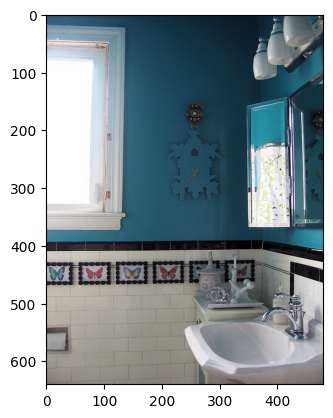

In [29]:
get_caption("/kaggle/input/coco-image-caption/train2014/train2014/COCO_train2014_000000318556.jpg")